In [113]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import * 

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

from scipy.interpolate import interp1d

#### Interpolate between every 2nd peak and plot residual of remaining peaks with interpolated function 

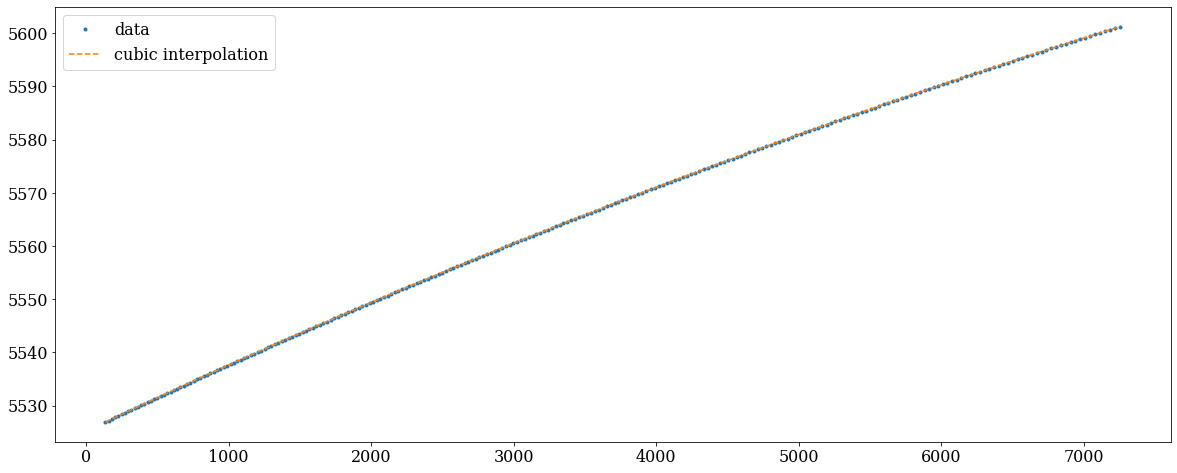

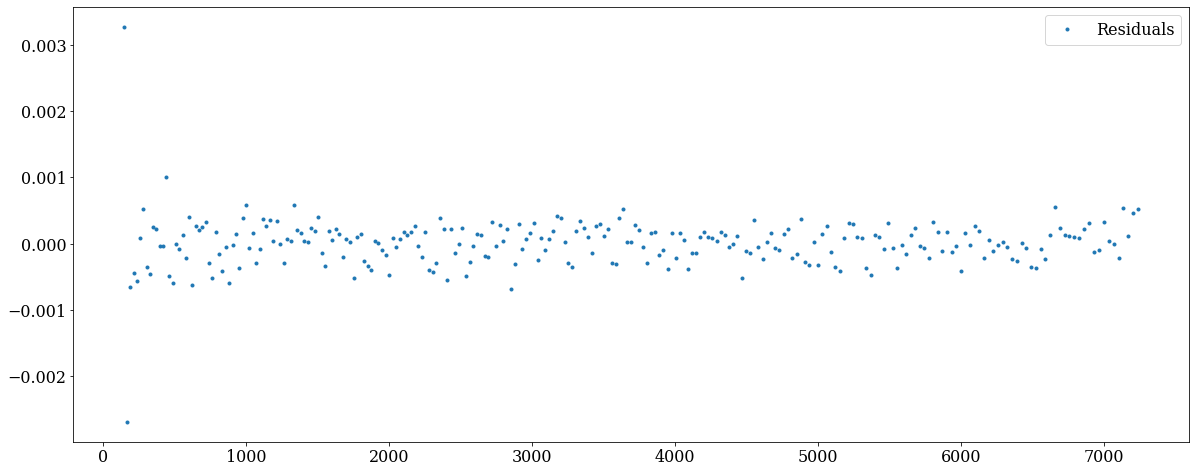

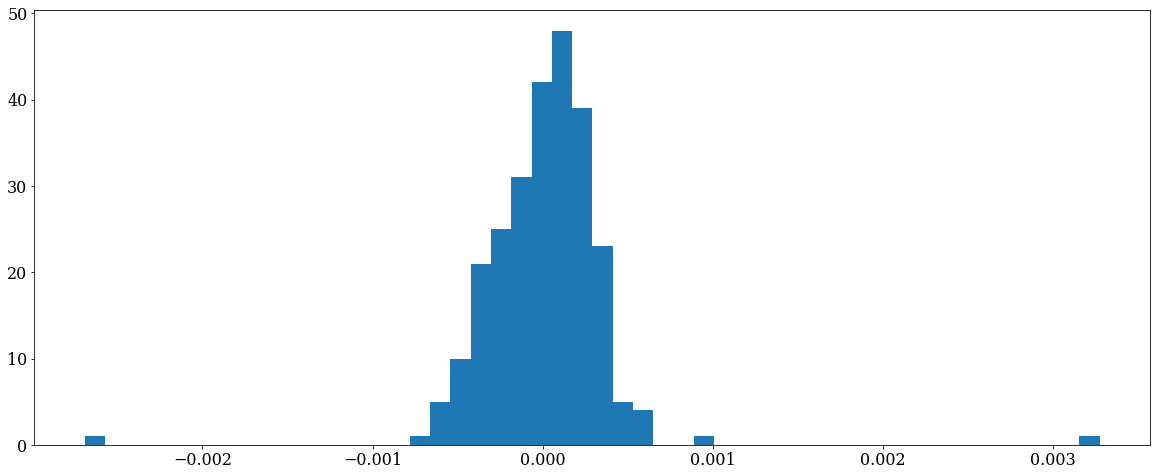

In [17]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)

order = 50
data = hdu1[1].data.copy()
data_spec       = data['spectrum'][order]
data_spec_err   = data['uncertainty'][order]
data_wavel      = data['wavelength'][order]

# Find peaks
peak_info = func_find_peaks(data_spec, 11, 0.15)
peak_locs = peak_info[0]

# Create data slices around each peak
peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size = 14)    # TODO: find dynamic way of choosing range size

# Fit peak in each data slice
peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

# Get list of true wavelengths
wavel_true = get_true_wavel(data_wavel, peak_locs)[:, 0] # second column is the n in the true wavel peak formula

# Take every other element
x = peak_fits[:,2][::2]
y = wavel_true[::2]

f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(min(x), max(x), 1000, endpoint=True)

plt.figure(figsize=(20,8))
plt.plot(x, y, '.', xnew, f2(xnew), '--')
plt.legend(['data', 'cubic interpolation'], loc='best')

# Residuals for all x and y
plt.figure(figsize=(20,8))
x = peak_fits[:,2][1::2] # Take every other element starting at index 1 (so we get the other ones)
y = wavel_true[1::2]
residuals = f2(x) - y
plt.plot(x, residuals, ".")
plt.legend(['Residuals'], loc='best')

# Plot residuals as hist
plt.figure(figsize=(20,8))
plt.hist(residuals, bins=50);

##### Repeat for all orders

In [115]:
results = fit_all_peaks_in_all_orders()

Standard deviation is  0.00020808149634317494


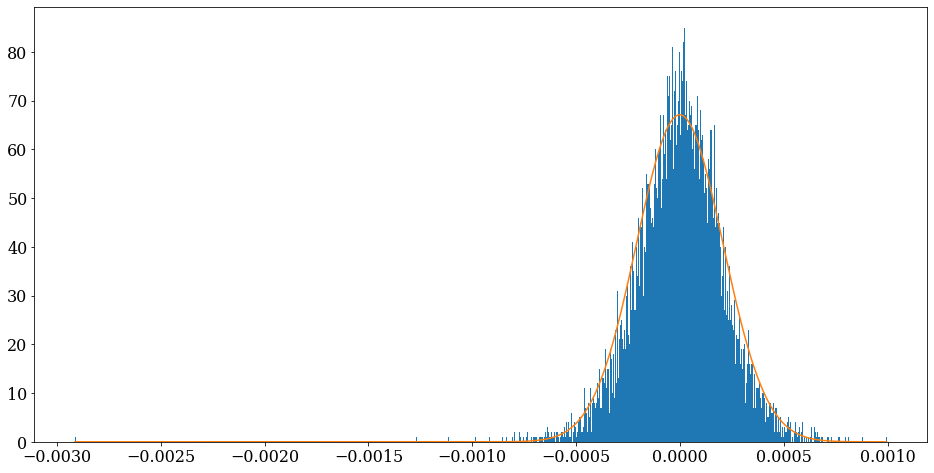

In [121]:
residuals = []
for o in range(40, 76):
    order, peak_fits, wavel_true, data_wavel = results[o]

    # Take every other element
    x = peak_fits[:,2][::2]
    y = wavel_true[::2][:, 0]

    f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

    # Residuals for all x and y
    x = peak_fits[:,2][1::2] # Take every other element starting at index 1 (so we get the other ones), and skip last item
    y = wavel_true[1::2][:, 0]
    x = x[1:-1]  # first and last data points don't work well — exclude them ... TODO ?
    y = y[1:-1]
    
    res = f2(x) - y # residuals
    residuals.append(res)

    # Plot all orders
    # fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
    # plt.gca().set_title(f"{order}. order")
    # ax1.plot(x, res, ".")
    # ax2.hist(res, bins=50);
    # fig.tight_layout()


# Plot all residuals
residuals = np.concatenate(residuals)
plt.figure(figsize=(16,8))
plt.hist(residuals, bins=1000);

print("Standard deviation is ", np.std(residuals))

# Draw gauss on top
xlin = np.linspace(min(residuals), max(residuals), 1000)
plt.plot(xlin, 0.035 * stats.norm.pdf(xlin, np.mean(residuals), np.std(residuals)))

# Save residuals to .csv
# np.savetxt("fit_results/residuals_interp_2nd_cropped.csv", residuals, delimiter=",")


#### Do interpolation for all except every 4th peak

/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_39196/3449436031.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = peak_fits[:,2][every_nth_mask]
/var/folders/pd/q4f8j97x0gv_zjtmdgf4r3g00000gn/T/ipykernel_39196/3449436031.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = wavel_true[every_nth_mask][:, 0]


Standard deviation is  0.00023380396558499706


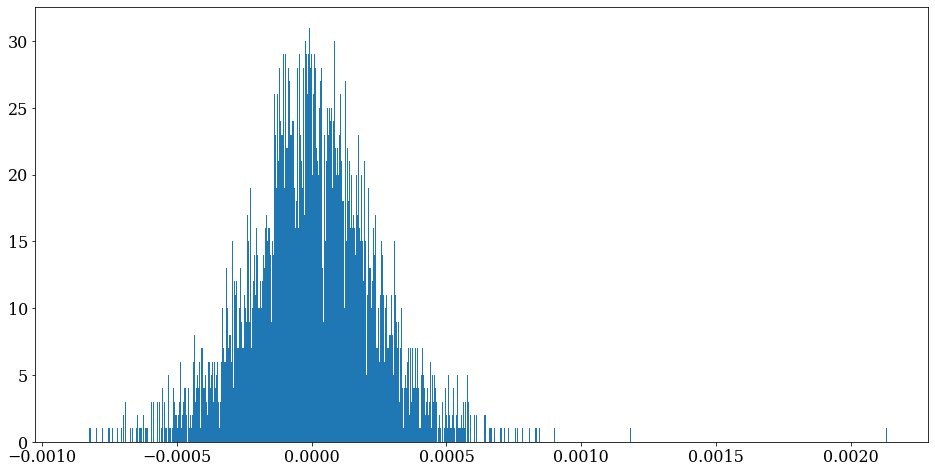

In [120]:
residuals = []
for o in range(40, 76):
    order, peak_fits, wavel_true, data_wavel = results[o]

    # Take every nth element
    nth = 4
    every_nth_mask = [np.mod(np.arange(peak_fits[:,2].size), nth) != 0]
    x = peak_fits[:,2][every_nth_mask]
    y = wavel_true[every_nth_mask][:, 0]

    f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

    # Residuals for all x and y
    x = peak_fits[:,2][::nth] # Take every other element starting at index 1 (so we get the other ones), and skip last item
    y = wavel_true[::nth][:, 0]
    x = x[1:-1]  # first and last data points don't work well — exclude them ... TODO ?
    y = y[1:-1]
    
    res = f2(x) - y # residuals
    residuals.append(res)

    # Plot all orders
    # fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
    # plt.gca().set_title(f"{order}. order")
    # ax1.plot(x, res, ".")
    # ax2.hist(res, bins=50);
    # fig.tight_layout()


# Plot all residuals
residuals = np.concatenate(residuals)
plt.figure(figsize=(16,8))
plt.hist(residuals, bins=1000);

print("Standard deviation is ", np.std(residuals))

# Draw gauss on top
xlin = np.linspace(min(residuals), max(residuals), 1000)
# plt.plot(xlin, 0.035 * stats.norm.pdf(xlin, np.mean(residuals), np.std(residuals)))

# Save residuals to .csv
# np.savetxt("fit_results/residuals_interp_2nd_cropped.csv", residuals, delimiter=",")


In [111]:
nth = 4
a = np.array([1,2,3,4,5,6,7,8,9,10])
b = a[::nth]
a = a[np.mod(np.arange(a.size), nth) != 0]
a, b

(array([ 2,  3,  4,  6,  7,  8, 10]), array([1, 5, 9]))

### Compare to 6 degree poly fit

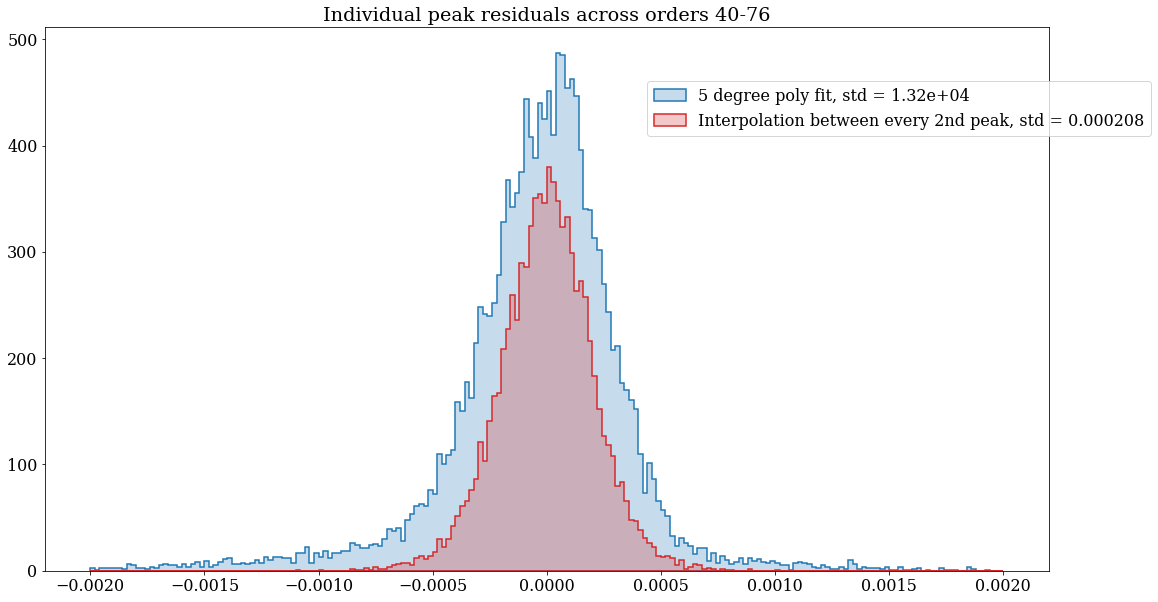

In [161]:
from matplotlib import colors

res_fit5 = np.genfromtxt("fit_results/residuals_5degree_fit.csv")
res_fit6 = np.genfromtxt("fit_results/residuals_6degree_fit.csv")
res_interp = np.genfromtxt("fit_results/residuals_interp_2nd_cropped.csv")

plt.figure(figsize=(18, 10))
mRange = (-0.002, 0.002)
plt.hist(res_fit5, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label=f"5 degree poly fit, std = {np.std(res_fit5):.3}");
plt.hist(res_interp, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C3', 0.25), edgecolor="C3", lw=1.5, label=f"Interpolation between every 2nd peak, std = {np.std(res_interp):.3}");
# plt.hist(res_fit6, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label="6 degree poly fit");
plt.title("Individual peak residuals across orders 40-76")
plt.legend(loc=[0.6, 0.8])

(1.7899265384383779e+19, 13239.38863158647)

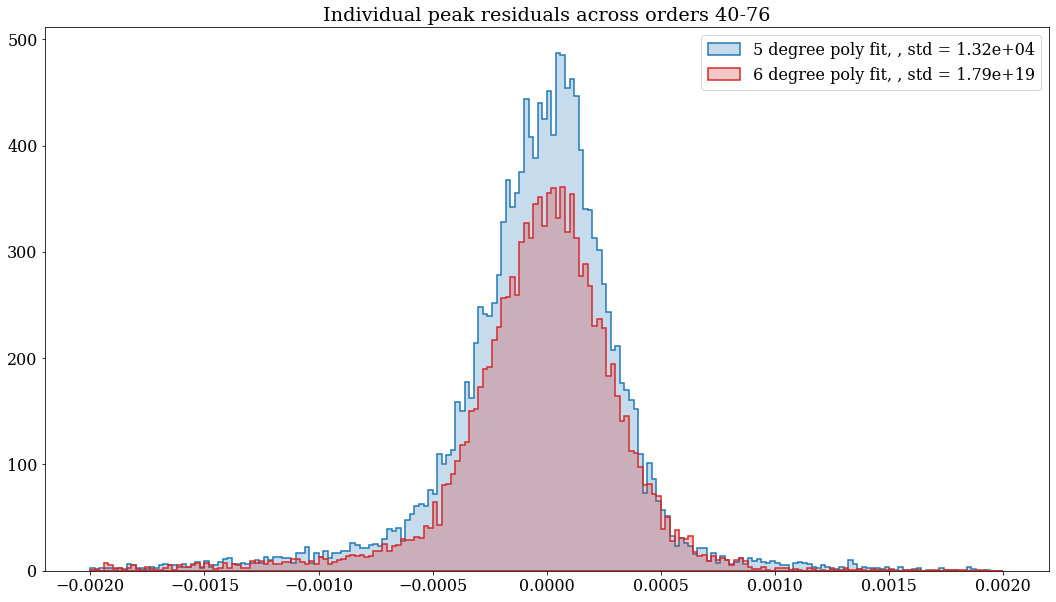

In [162]:
from matplotlib import colors

res_fit5 = np.genfromtxt("fit_results/residuals_5degree_fit.csv")
res_fit6 = np.genfromtxt("fit_results/residuals_6degree_fit.csv")

plt.figure(figsize=(18, 10))
mRange = (-0.002, 0.002)
plt.hist(res_fit5, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label=f"5 degree poly fit, , std = {np.std(res_fit5):.3}");
plt.hist(res_fit6, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C3', 0.25), edgecolor="C3", lw=1.5, label=f"6 degree poly fit, , std = {np.std(res_fit6):.3}");
plt.title("Individual peak residuals across orders 40-76")
plt.legend()

np.std(res_fit6), np.std(res_fit5)

### Save interpolation function for calibration use

In [105]:
# for o in range(40, 76):
o = 45
order, peak_fits, wavel_true, data_wavel = results[o]

# Take every other element
x = peak_fits[:,2][::2]
y = wavel_true[::2][:, 0]

f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

f2(4032)

# Save scipy object
np.save(f"fit_results/interp_order{o}.npy", f2, allow_pickle=True)

# To load scipy object
# f3 = np.load("fit_results/interpolation.sci.npy", allow_pickle=True).item(0)


array(5329.00576727)